# Is there a relationship between exchange rate and hash rate?

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [3]:
# Import Hash Rate Data
hashd = pd.read_csv('eth_hash.csv')
hashd.drop(columns=['UnixTimeStamp'],inplace=True)
hashd.columns = ['date','rate']
hashd.set_index(pd.to_datetime(hashd['date']),inplace=True)
hashd.drop(columns=['date'], inplace=True)
hashd = hashd['2019-01-01':]

In [4]:
# Import Price Data
start = '2019-01-01'#str(hashd.index[0]).split(" ")[0]
end = str(hashd.index[-1]).split(" ")[0]
data = yf.download('ETH-USD', start = start, end = end, interval = '1d').Close.copy()

[*********************100%***********************]  1 of 1 completed


In [5]:
data = pd.DataFrame(data)
data['hash'] = hashd
data = data[:-1]

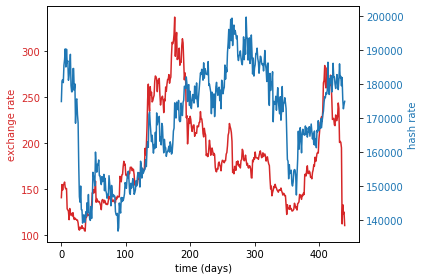

In [6]:
x = np.arange(0,len(data))
fig, ax1 = plt.subplots()
plt.rcParams["figure.figsize"]=10,5
color = 'tab:red'
ax1.set_xlabel('time (days)')
ax1.set_ylabel('exchange rate', color=color)
ax1.plot(x, data.Close, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('hash rate', color=color)  # we already handled the x-label with ax1
ax2.plot(x, data.hash, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

It appears that there may be a relationship between these two variables when one of them is lagged. For this experiment, we will empirically determine the lag time that allows the exchange rate to explain the hash rate.

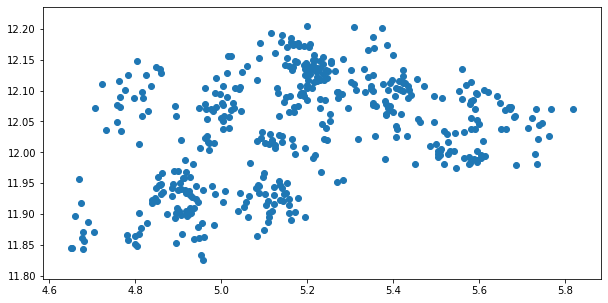

In [9]:
# Plot the Scatter of the data
plt.scatter(np.log(data.Close),np.log(data.hash))


In [7]:
# Shift the Exchange Rate Forward
R = []
results=[]
lags = np.arange(1,100)
x = np.log(data.Close.values.astype('float64'))
y = np.log(data.hash.values.astype('float64'))
for lag in lags:
    X = x[:-lag]
    Y = y[lag:]
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    res = model.fit()
    R.append(res.rsquared)
    results.append(res)

In [8]:
opt_lag = lags[np.argmax(R)]
a = results[np.argmax(R)].params[0]
b = results[np.argmax(R)].params[1]
print('Optimum Lag Period is %d days'%opt_lag)

Optimum Lag Period is 87 days


In [9]:
data['lag'] = data.Close.shift(opt_lag)

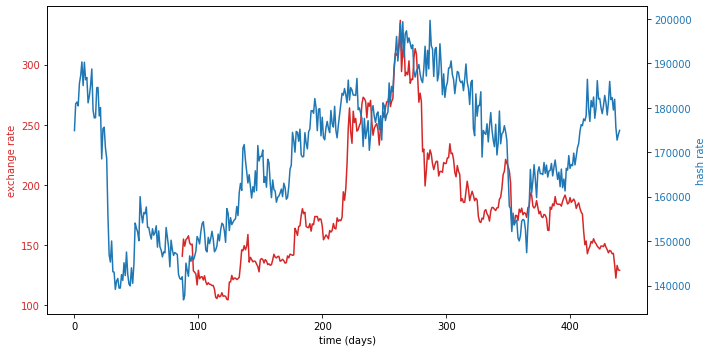

In [10]:
x = np.arange(0,len(data))
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (days)')
ax1.set_ylabel('exchange rate', color=color)
ax1.plot(x, data.lag, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('hash rate', color=color)  # we already handled the x-label with ax1
ax2.plot(x, data.hash, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

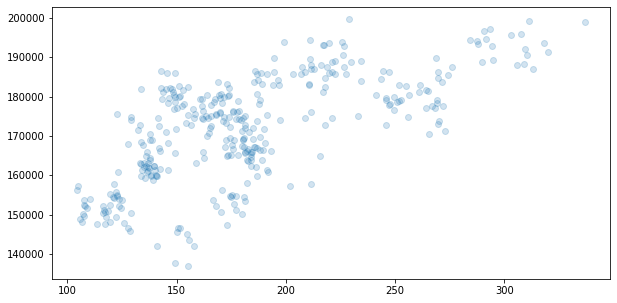

In [11]:
# Remove the Data Points that Deviate too much from the mean
data['delta'] = data.Close - data.Close.shift(20).values
data.dropna(inplace=True)


plt.scatter(data.lag.values,data.hash.values,alpha=0.2)
plt.show()

In [12]:
X = sm.add_constant(np.log(data.lag.values))
Y = np.log(data.hash.values)
model = sm.OLS(Y,X,missing='drop')
results = model.fit()

In [13]:
print(results.params)
a, b = results.params
# Characteristics of the residuals

resid = results.resid
mu = resid.mean()
dev = resid.std()
print(mu,dev)

[11.00129771  0.20303128]
-1.13405832119903e-15 0.057573662454023455


In [14]:
Y_fit = np.exp(a)*(data.lag**b)*np.exp(np.random.normal(loc=mu,scale=dev**2,size=len(data.lag)))

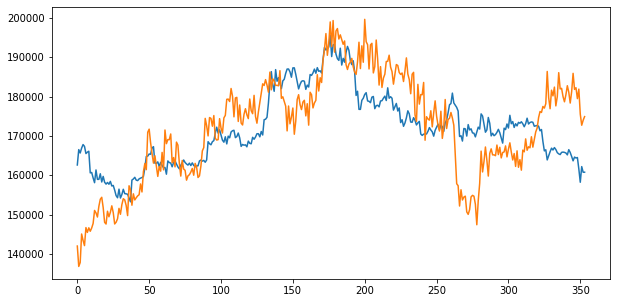

In [15]:
plt.plot(np.arange(0,len(Y_fit)),Y_fit)
plt.plot(np.arange(0,len(data.hash)),data.hash)
plt.show()

In [16]:
# Characteristics of the residuals

resid = results.resid

In [17]:
mu = resid.mean()
dev = resid.std()
print(mu,dev)

-1.13405832119903e-15 0.057573662454023455
